In [1]:
import numpy as np
import tensorflow as tf
import math as m


BATCH_SIZE = 300
num_iterations = 500
N = 250

class Data:
	def __init__(self):
		
		sigma_noise = 0.2
		a = 2
		b = 1
		theta_offset = m.pi
		self.index = np.arange(2*N)
		self.theta = np.random.uniform(low = -4.5*m.pi, high = -m.pi, size=(N,1))
		self.theta2 = self.theta+theta_offset	
		self.noise1 = np.random.normal(scale = sigma_noise, size = (N,1))
		self.noise2 = np.random.normal(scale = sigma_noise, size = (N,1))
		self.r1 = a+b*self.theta+self.noise1
		self.r2 = a+b*self.theta+self.noise2
		
		self.x1 = self.r1*np.cos(self.theta)
		self.y1 = self.r1*np.sin(self.theta)
		self.x2 = self.r2*np.cos(self.theta2)   
		self.y2 = self.r2*np.sin(self.theta2)

		self.r_theta1 = np.concatenate((self.r1,self.theta), axis = 1)
		self.r_theta2 = np.concatenate((self.r2,self.theta2), axis = 1)
		self.x = np.concatenate((self.r_theta1,self.r_theta2), axis = 0)

		self.t1 = np.ones(shape = (N,1))
		self.t2 = np.zeros(shape = (N,1))
		self.t = np.concatenate((self.t1, self.t2), axis = 0)

	def get_class1_coordinates(self):
		return self.x1, self.y1
	def get_class2_coordinates(self):
		return self.x2, self.y2
	def get_data(self):
		return self.x, self.t
	def get_batch(self):
		choices = np.random.choice(self.index, size = BATCH_SIZE)
		return self.x[choices], self.t[choices]

data = Data()

def f(x):
	w1 = tf.get_variable('w1', [2, 4], tf.float32,
						tf.random_normal_initializer())
	b1 = tf.get_variable('b1', [4], tf.float32,
						tf.zeros_initializer())
	w2 = tf.get_variable('w2', [4,1], tf.float32,
						tf.random_normal_initializer())                       
	b2 = tf.get_variable('b2', [1], tf.float32,
						tf.zeros_initializer())                    					                      
	g = tf.nn.relu(tf.matmul(x, w1)+b1)
	return tf.matmul(g,w2)+b2

x = tf.placeholder(tf.float32, [BATCH_SIZE,2])
y = tf.placeholder(tf.float32, [BATCH_SIZE,1])
y_hat = f(x)

cross_entropy_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = y, logits = y_hat)
loss = tf.reduce_mean(cross_entropy_loss)
l2_loss = 0.001 * tf.add_n(
     [tf.nn.l2_loss(v) for v in tf.trainable_variables()])

loss += l2_loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

losses = []
for _ in range(num_iterations):
	x_batch, y_batch = data.get_batch()
	loss_np, _ = sess.run([loss, optimizer], feed_dict={x: x_batch, y: y_batch})
	losses.append(loss_np)

parameters = []
for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
	parameter = np.array(sess.run(var))
	parameters.append(np.array(parameter))
w1, b1, w2, b2 = parameters

def ReLU(x):
	return x*(x>0)
def sigmoid(x):
	return 1 / (1 + np.exp(-x))
def f_(x):
	return sigmoid( ReLU(x@w1+b1)@w2+b2 )


In [2]:
x_,y_ = data.get_data()
num_correct = 0

for i, sample in enumerate(x_):
	if (f_(sample) < 0.5) and (y_[i] == 0):
		num_correct += 1
	elif (f_(sample) > 0.5) and (y_[i] == 1):
		num_correct += 1
percent_correct = num_correct/(len(y_))*100
print('Percent Correct on Training Set: ', percent_correct)

Percent Correct on Training Set:  100.0


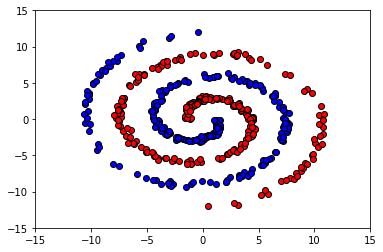

In [4]:
x_1,y_1 = data.get_class1_coordinates()
x_2,y_2 = data.get_class2_coordinates()

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x_1, y_1, color = 'b', edgecolors = 'black')
plt.scatter(x_2, y_2, color = 'r', edgecolors = 'black')
axes = plt.gca()
axes.set_xlim([-15,15])
axes.set_ylim([-15,15])

plt.show()